# Language in Space

## Session 05: Clustering, Multi-dimensional scaling

### Gerhard Jäger

November 25, 2021


In [1]:
library(tidyverse)
library(ggrepel)

padPath = "data/PAD/" # may be different on your computer



── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
words = read_tsv(paste0(padPath, "/data/words.csv"), comment="#")



── Column specification ────────────────────────────────────────────────────────
cols(
  ID = col_double(),
  CONCEPT = col_character(),
  COUNTERPART = col_character(),
  CONCEPTID = col_double(),
  DOCULECT = col_character(),
  TOKENS = col_character(),
  COGID = col_double()
)




In [3]:
doculects = read_tsv(paste0(padPath, "/data/doculects.csv"), comment="#")



── Column specification ────────────────────────────────────────────────────────
cols(
  ID = col_double(),
  LONGITUDE = col_double(),
  LATITUDE = col_double(),
  NAME = col_character(),
  SHORT_NAME = col_character(),
  TRANSCRIPTOR = col_character()
)




In [4]:
cognatesets = read_tsv(paste0(padPath, "/data/cognatesets.csv"), comment="#")



── Column specification ────────────────────────────────────────────────────────
cols(
  COGNATE = col_character(),
  COGNATE_ID = col_double(),
  NUMBER_OF_WORDS = col_double(),
  WENKER_ID = col_double(),
  WENKER_SENTENCE = col_character()
)




In [5]:
freqTable <- words %>% 
    group_by(DOCULECT) %>% 
    summarise(n=n()) %>% 
    arrange(desc(n))



In [6]:
doculectsWithFrequency <- freqTable %>% 
    rename(SHORT_NAME = DOCULECT) %>% 
    inner_join(doculects)



Joining, by = "SHORT_NAME"



In [7]:
alignmentFiles <- list.files(paste0(padPath, "alignments/corrected"), full.names = T)


In [10]:

alignmentsL = list()
for (i in 1:length(alignmentFiles)) {
  al <- read_tsv(alignmentFiles[i], 
         comment = "#", 
         quote = "")  %>%
      filter(`:ANN` != ":ANN") %>%
      rename(COLUMNID = 2) %>%
      distinct(COLUMNID, .keep_all=T) %>%
      mutate(doculect = str_replace_all(COLUMNID, "\\.", "")) %>%
      select(`:ANN`, doculect, matches("[0-9]+")) %>%
      pivot_longer(matches("[0-9]+"), names_to = "position", values_to = "segment") %>%
      mutate(msa = i) %>%
      filter(segment != "-")
  alignmentsL[[i]] = al
}  

alignments <- alignmentsL %>%
  bind_rows()



── Column specification ────────────────────────────────────────────────────────
cols(
  `:ANN` = col_character(),
  COLUMNID....... = col_character(),
  `1` = col_character(),
  `2` = col_character(),
  `3` = col_character(),
  `4` = col_character(),
  `5` = col_character(),
  `6` = col_character(),
  `7` = col_character(),
  `8` = col_character(),
  `9` = col_character(),
  `10` = col_character(),
  `11` = col_character(),
  `12` = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  `:ANN` = col_character(),
  COLUMNID....... = col_character(),
  `1` = col_character(),
  `2` = col_character(),
  `3` = col_character(),
  `4` = col_character(),
  `5` = col_character(),
  `6` = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  `:ANN` = col_character(),
  COLUMNID....... = col_character(),
  `1` = col_character(),
  `2` = col_character(),
  `3` = col_character(),
  `4` =

In [11]:
segmentFreqs <- alignments %>% 
  group_by(segment) %>%
  summarise(q = n()) %>%
  arrange(desc(q))

In [12]:
minFrequency = 50

alignmentsPruned <- alignments %>% 
  inner_join(segmentFreqs) %>%
  filter(q >= minFrequency)


Joining, by = "segment"



In [13]:

segmentLevels <- alignmentsPruned %>%
  select(segment) %>%
  distinct() %>% .[[1]]


In [14]:
nSegments = length(segmentLevels)

In [15]:
d <- alignmentsPruned %>% 
  mutate(sf = factor(segment, segmentLevels)) %>%
  mutate(segment_index = as.numeric(sf)) %>% 
  select(!sf)



In [16]:

getP <- function(x) {
  pairCounts <- matrix(0, nSegments, nSegments)
  for (i in x$segment_index) {
    for (j in x$segment_index) {
      pairCounts[i,j] = pairCounts[i,j] + 1
    }
  }
  return(pairCounts)
}


In [17]:

aCols = d %>%
  select(msa, position) %>%
  distinct()



In [18]:
p <- matrix(1, nSegments, nSegments) # add-1 smoothing


for (i in 1:nrow(aCols)) {
  p <- p + d %>%
    filter(msa == aCols$msa[i]) %>%
    filter(position == aCols$position[i]) %>%
    getP
}

rownames(p) <- segmentLevels
colnames(p) <- segmentLevels



In [19]:
q_vector = segmentFreqs$q
names(q_vector) <- segmentFreqs$segment

q_vector <- q_vector[segmentLevels]

In [20]:
pmi <- matrix(0, nSegments, nSegments)

rownames(pmi) <- segmentLevels
colnames(pmi) <- segmentLevels

logP <- log(sum(p))
logQ <- log(sum(q_vector))

for (i in 1:nSegments) {
  for (j in 1:nSegments) {
    pmi[i,j] <- log(p[i,j]) - logP - log(q_vector[i]) - log(q_vector[j]) + 2*logQ
  }
}



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



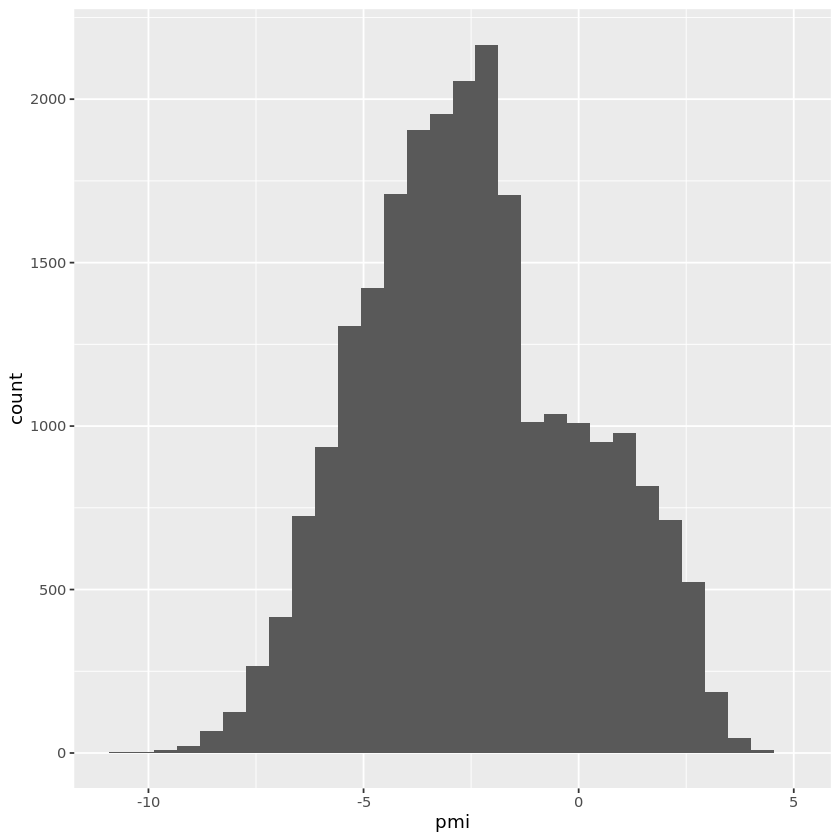

In [21]:
tibble(pmi=c(as.dist(pmi))) %>%
    ggplot() +
    geom_histogram(aes(x=pmi))

We can use MDS to visualize complex patterns in two or three dimensions if we have a dissimilarity measure.

E.g., we can convert the PMI between sound classes into a dissimilarity measure.

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
Using compatibility `.name_repair`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Warning message:
“ggrepel: 100 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


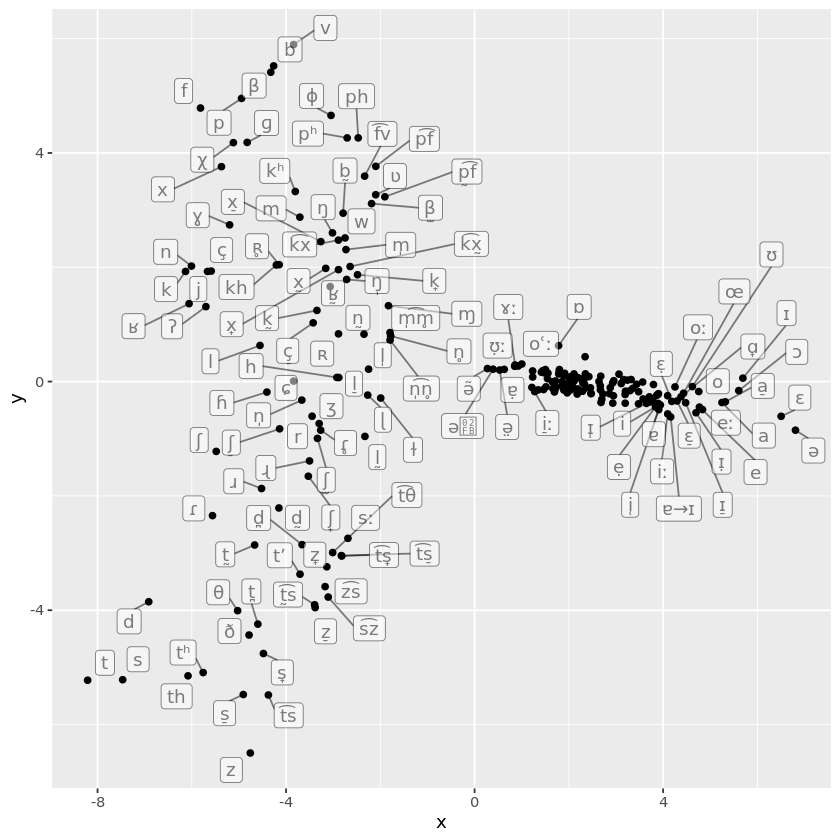

In [22]:
pmiDists <- max(pmi) - pmi

mds <- pmiDists %>%
    cmdscale() %>%
    as_tibble() %>% 
    rename(x=1, y=2) %>%
    mutate(soundclass = segmentLevels)

mds %>%
    ggplot() +
    geom_point(aes(x=x, y=y)) +
    geom_label_repel(aes(x=x, y=y, label=soundclass), max.overlaps=50, alpha=.5)
    

Warning message in dist(mds):
“NAs introduced by coercion”
`geom_smooth()` using formula 'y ~ x'



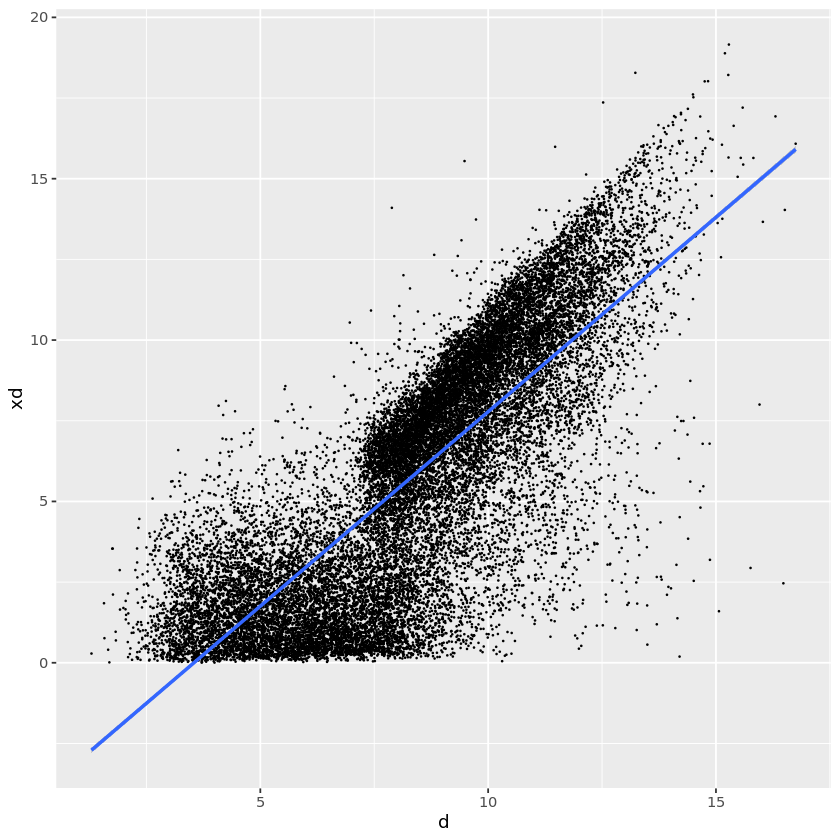

In [23]:
data.frame(d=c(as.dist(pmiDists)), xd=c(dist(mds))) %>%
    ggplot() + 
    geom_point(aes(x=d, y = xd), size=0.1) +
    geom_smooth(aes(x=d, y=xd), method=lm)

## Hierarchical clustering

In [24]:
?hclust

hclust {stats},R Documentation
d,a dissimilarity structure as produced by dist.
method,"the agglomeration method to be used. This should be (an unambiguous abbreviation of) one of ""ward.D"", ""ward.D2"", ""single"", ""complete"", ""average"" (= UPGMA), ""mcquitty"" (= WPGMA), ""median"" (= WPGMC) or ""centroid"" (= UPGMC)."
members,NULL or a vector with length size of d. See the ‘Details’ section.
x,an object of the type produced by hclust.
hang,The fraction of the plot height by which labels should hang below the rest of the plot. A negative value will cause the labels to hang down from 0.
check,"logical indicating if the x object should be checked for validity. This check is not necessary when x is known to be valid such as when it is the direct result of hclust(). The default is check=TRUE, as invalid inputs may crash R due to memory violation in the internal C plotting code."
labels,A character vector of labels for the leaves of the tree. By default the row names or row numbers of the original data are used. If labels = FALSE no labels at all are plotted.
"axes, frame.plot, ann",logical flags as in plot.default.
"main, sub, xlab, ylab",character strings for title. sub and xlab have a non-NULL default when there's a tree$call.
...,"Further graphical arguments. E.g., cex controls the size of the labels (if plotted) in the same way as text."


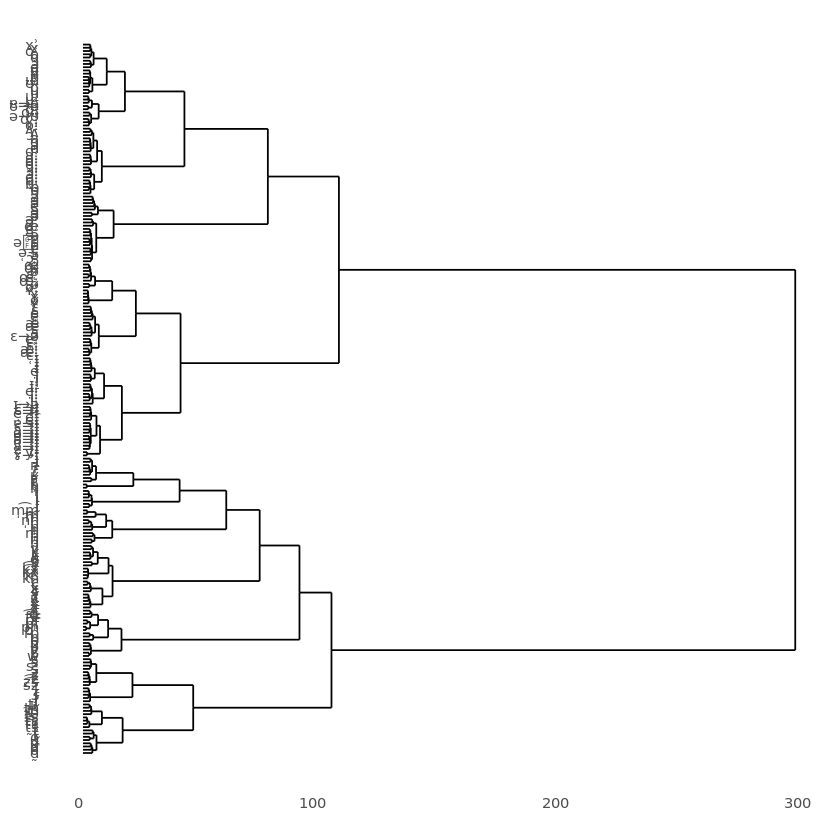

In [25]:
library(ggdendro)


hc <- pmiDists %>%
  as.dist() %>%
  hclust(method="ward.D")

ggdendrogram(hc, rotate = T, size=.05)
#ggsave("hierarchicalClustering.svg")

Cut the tree at a height that gives 30 clusters. (30 is an arbitray but reasonable number).

In [26]:
nClasses = 30

soundClasses = cutree(hc, k=nClasses) %>% as.numeric()


In [27]:
for (i in 1:nClasses) {
    print(paste0(segmentLevels[soundClasses == i], collapse=" "))
}

[1] "ɔ ɤ o ɔ̣ o̜ oʿ ọ ɤʾ"
[1] "β v w ʋ β̫"
[1] "ə̟ ə ə̃ ə̰ ə̣ e̠ ə̤"
[1] "n n̰ ŋ ɱ"
[1] "t t̰ d θ t̪ ð d̰ d̪"
[1] "ɔː ɒ ɑ̟ ɒː ɔ̜ o̜ː ɑː ɔ̣ː ɒ̣ː ɑʾ ɒ̣ ɔ̜ː ʌ a̠ː a̠ ɔʿ ɑ̟ː aː a ɑ ʌʾ"
[1] "b b̰ p"
[1] "n̩ n̥ n̩͡n̥ ŋ̩"
[1] "m m̩ m̩͡m̥"
[1] "oː ɤː oʿː u̜ː ɐ→ʊ ə→ʊ ʊ̣ː uː o͡ʊ ʊ→ə"
[1] "tʰ th tʼ t͡θ"
[1] "ɔ̟ ə̠ ɐ əʾ ə̟ʾ ə̜ œ̠ ə̜+ ə̠ʾ ɐʾ ə˻ ɐ̟ ɐ̣ ɔ̟ʿ"
[1] "t̰͡s t͡s̠ t͡s t͡s̟"
[1] "ʔ k ɡ ɣ k̰ k̟ j"
[1] "ɸ pʰ p̰͡f ph p͡f f f͡v"
[1] "s z̠ s̠ s̟ z͡s z z̟ s͡z sː"
[1] "ʀ̥ x χ x̠ x̰"
[1] "x̟ ç ɕ ç̠"
[1] "ɛ̠ ɛː ɛ ɛ̜ æ̣ e̜ e ɛ̣ ạ æ ɛ̣ː ɛ̜ː e̜ː ɛ→ə̜ æː æ̣ː"
[1] "h ɦ"
[1] "ẹ ɪ ɪ̣ ɪ̜ ɪ̠ i̜ i i̠"
[1] "l l̠ l̩ ɭ ɫ l̰"
[1] "œʿ œ̣ œ øː ø̜ ɛʾ ø œː"
[1] "ʃ ʒ ʃ̠ ʃ̟ ʃ̫"
[1] "eː a→ɪ ɤ→ɪ e̜→ɪ a̠→ɪ̜ e͡ɪ ɛ̠→ɪ a̠→ɪ ɐ→ɪ ɐ̟→ɪ ɛ→ɪ yː ɛ̜→ɪ ạ→ɪ ɛ̣→ɪ ɐ̠→ɪ"
[1] "ʏ ʏ̜ ʏ̣ ʏʿ ø̣"
[1] "ɾ̥ ʁ r ɾ ɹ ʁ̰ ʀ ɻ"
[1] "k͡x̰ kh kʰ k͡x"
[1] "ʊ ɯ ʊ̣ ʊ̜ u̜ ʊ̟ ʊʿ u"
[1] "ɪː ɪ̣ː i̜ː iː i̠ː ɪ→ə ẹː"


add soundclass index to alignments

In [28]:
d

:ANN,doculect,position,segment,msa,q,segment_index
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>
3304,Aachen,6,ɔ,1,1023,1
3304,Aachen,7,β,1,2473,2
3304,Aachen,8,ə̟,1,645,3
3304,Aachen,9,n,1,6258,4
3304,Aachen,11,t,1,5782,5
3407,Adorf,6,ɔː,1,231,6
3407,Adorf,7,b,1,1874,7
3407,Adorf,9,n̩,1,1523,8
3407,Adorf,11,t,1,5782,5


In [29]:

d <- d %>%
  mutate(soundclass_index = soundClasses[segment_index])

d %>% slice_tail(n=10)

:ANN,doculect,position,segment,msa,q,segment_index,soundclass_index
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>
13022,Wüllen,1,t,185,5782,5,5
13022,Wüllen,3,β,185,2473,2,2
13022,Wüllen,4,ɛ̜,185,254,88,19
13022,Wüllen,6,ɫ,185,120,100,22
13022,Wüllen,8,f,185,4017,107,15
13171,Zellingen,1,t͡s,185,698,61,13
13171,Zellingen,3,β,185,2473,2,2
13171,Zellingen,4,øː,185,184,117,23
13171,Zellingen,6,l,185,4932,85,22


Function for computing the Hamming distance based on sound classes.

In [30]:

hammingDistance <- function(l1, l2) {
  d1 <- d %>% 
    filter(doculect == l1)
  d2 <- d %>%
    filter(doculect == l2)
 d1 %>%
    full_join(d2, by = c("msa", "position")) %>%
    replace_na(list(soundclass_index.x = 0, soundclass_index.y = 0)) %>%
    select(msa, position, soundclass_index.x, soundclass_index.y, `:ANN.x`, `:ANN.y`) %>%
    mutate(neq = soundclass_index.x != soundclass_index.y) %>%
    group_by(msa) %>%
    summarize(hamming = mean(neq)) %>%
    .$hamming %>% 
    mean() %>%
    return()
}


Computer pairwise Hamming distances.

In [31]:
doculects = unique(d$doculect)

nDoculects = length(doculects)

dstMtx = matrix(0, nDoculects, nDoculects)

for (i in 1:nDoculects) {
  for (j in 1:nDoculects) {
    if (i < j) {
      dstMtx[i,j] <- dstMtx[j,i] <- hammingDistance(doculects[i], doculects[j])
    }
  }
}

rownames(dstMtx) <- doculects
colnames(dstMtx) <- doculects


Apply MDS with 3 dimensions, map each resulting 3d-vector to colors, and plot on map.

In [32]:
fit.doculects <- cmdscale(dstMtx, k = 3)


In [33]:
doculects.mds <- 
  as_tibble(fit.doculects) %>%
  mutate(doculect = rownames(fit.doculects)) %>%
  mutate(x = V1 - min(.$V1), y = V2 - min(.$V2), z = V3 - min(.$V3)) %>%
  mutate(r = x / max(.$x), g = y / max(.$y), b = z / max(.$z)) %>%
  mutate(col = rgb(r,g,b)) %>%
  select(doculect, col, r, g, b)

doculects.mds

doculect,col,r,g,b
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Aachen,#7A6AFF,0.47987992,0.41514144,1.00000000
Adorf,#96C472,0.58886437,0.76976499,0.44873298
Ahrbergen,#118D67,0.06593783,0.55349682,0.40519532
Albersloh,#1FB996,0.12159640,0.72600783,0.58681950
Allna,#8F26EC,0.55937654,0.14830110,0.92597877
Altenberg,#691035,0.41288134,0.06109255,0.20732644
Altentrüdin,#F4A19E,0.95778260,0.63315217,0.61765899
Altlandsberg,#5C163F,0.36097274,0.08767581,0.24745553
Altwarp,#1A9470,0.10195455,0.58142892,0.44011161



── Column specification ────────────────────────────────────────────────────────
cols(
  ID = col_double(),
  LONGITUDE = col_double(),
  LATITUDE = col_double(),
  NAME = col_character(),
  SHORT_NAME = col_character(),
  TRANSCRIPTOR = col_character()
)


Joining, by = "doculect"



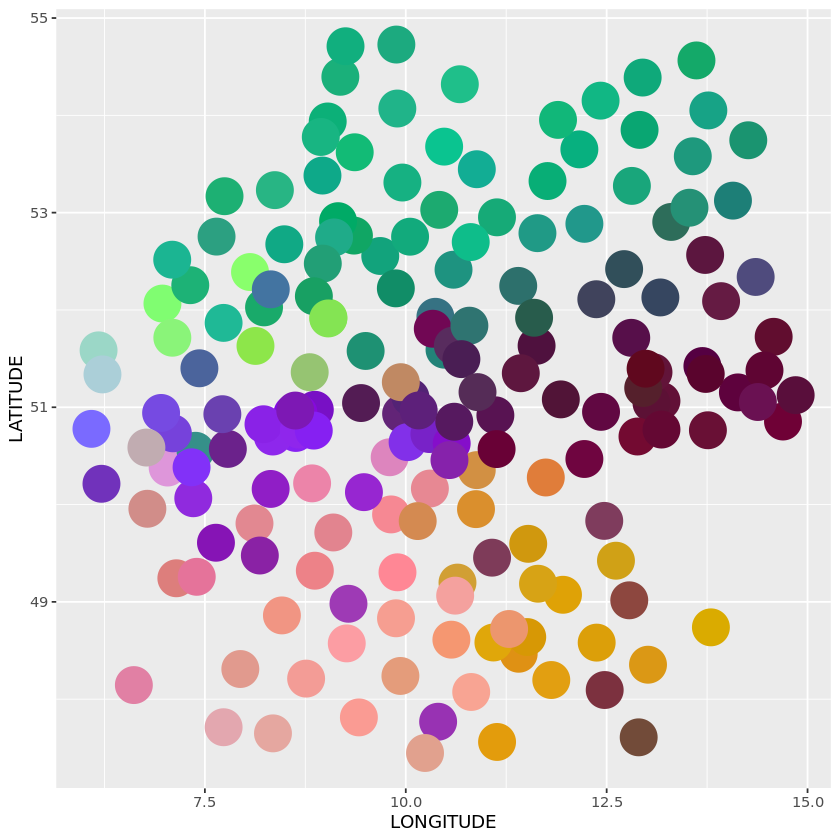

In [34]:
doculectTbl <- read_tsv(paste0(padPath, "data/doculects.csv"), comment="#") %>%
  rename(doculect = SHORT_NAME) %>%
  select(doculect, LONGITUDE, LATITUDE) %>%
  inner_join(doculects.mds)


ggplot(doculectTbl) +
  geom_point(aes(x=LONGITUDE, y = LATITUDE), col=doculectTbl$col, size=10)




 visualizing the three features separately

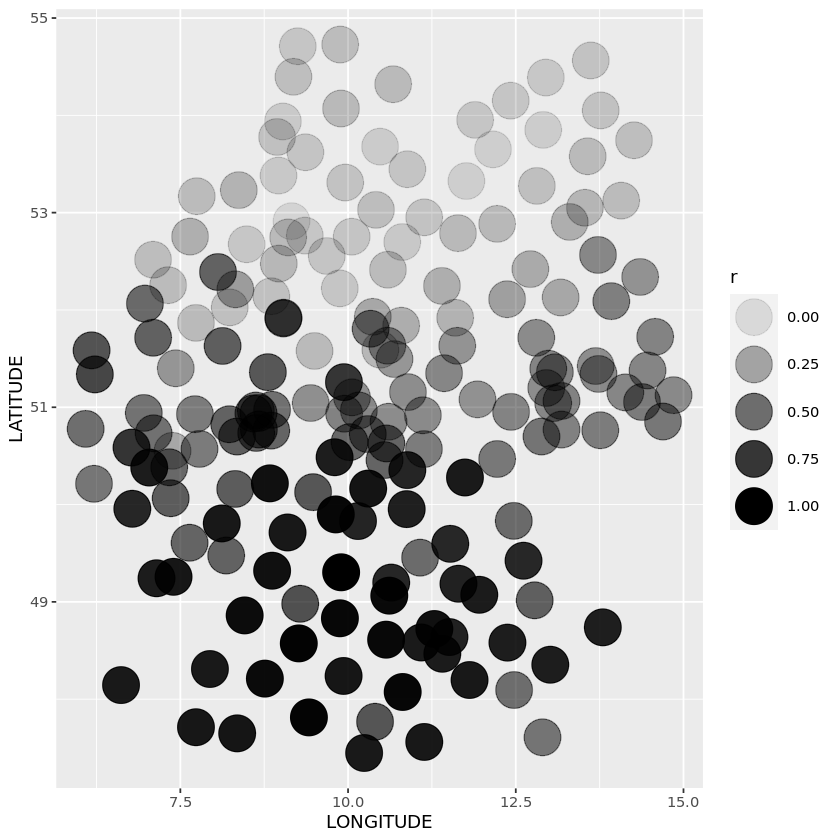

In [35]:

ggplot(doculectTbl) +
  geom_point(aes(x=LONGITUDE, y = LATITUDE, alpha=r), size=10)




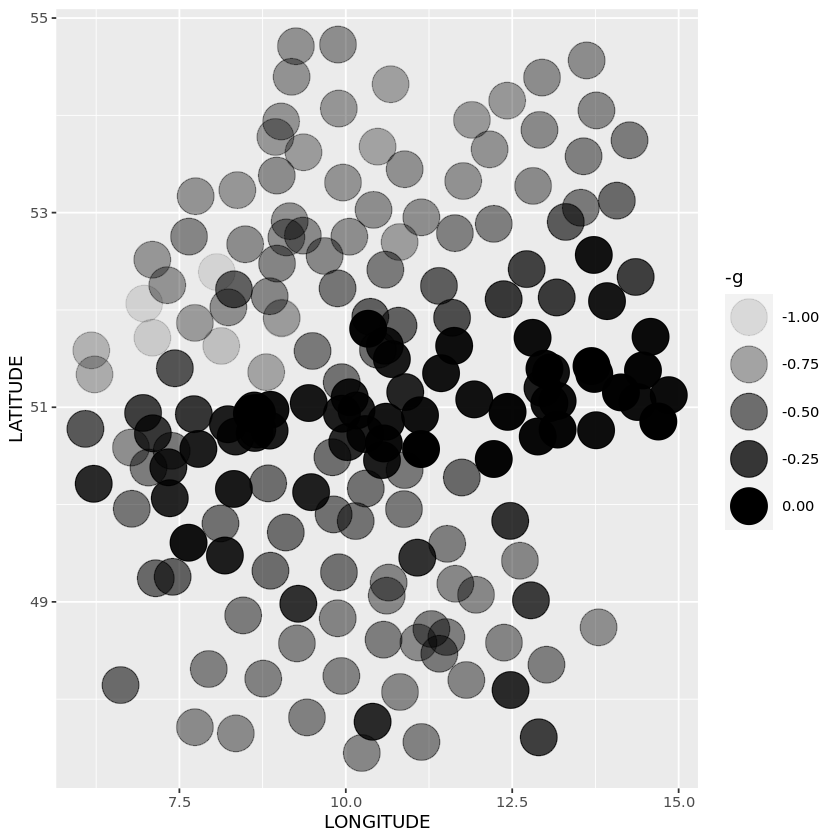

In [36]:

ggplot(doculectTbl) +
  geom_point(aes(x=LONGITUDE, y = LATITUDE, alpha=-g), size=10)



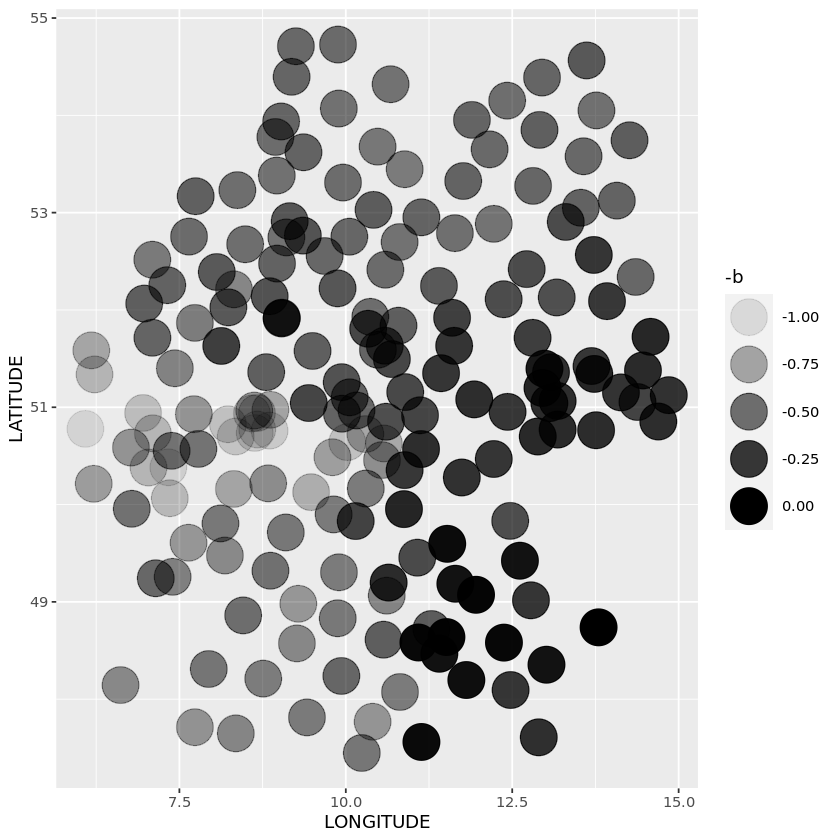

In [37]:

ggplot(doculectTbl) +
  geom_point(aes(x=LONGITUDE, y = LATITUDE, alpha=-b), size=10)


